# [NoiseNCA: Noisy Seed Improves Spatio-Temporal Continuity of Neural Cellular Automata](https://noisenca.github.io)

You can find the original paper on [arxiv](https://arxiv.org/abs/2404.06279)

This notebook allows you to train a NoiseNCA model and create multi scale textures.

* **Notice that the code here is a simplified version of the code on the GitHub repo. This code is only meant for a quick hands on introduction. For comparison and evaluating your model against NoiseNCA please refer to the GitHub repo.**

* Some parts of this notebook are adapted from the [PyTorch Notebook](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb) for the Self Organizing Textures article on Distill.




In [ ]:
# @title Imports and Notebook Utilities
# This block is mostly taken from the self-org textures notebook.
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        # wikimedia requires a user agent
        headers = {
            "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
        }
        r = requests.get(url, headers=headers)
        f = io.BytesIO(r.content)
    else:
        f = url
    img = PIL.Image.open(f)
    if max_size is not None:
        img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
    if mode is not None:
        img = img.convert(mode)
    img = np.float32(img) / 255.0
    return img


def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()


def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg', id=None):
    return display(Image(data=imencode(a, fmt)), display_id=id)


def grab_plot(close=True):
    """Return the current Matplotlib figure as an image"""
    fig = pl.gcf()
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer._renderer)
    a = np.float32(img[..., 3:] / 255.0)
    img = np.uint8(255 * (1.0 - a) + img[..., :3] * a)  # alpha
    if close:
        pl.close()
    return img



def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e7b6a59b-a465-4d8d-31be-9b92bd34cb9d)


In [ ]:
import torch
import torchvision.models as models

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
#@title Define Style Loss


class RelaxedOTLoss(torch.nn.Module):
    """https://arxiv.org/abs/1904.12785"""
    def __init__(self, vgg, target_image, n_samples=1024):
        super().__init__()
        self.n_samples = n_samples
        self.vgg = vgg
        with torch.no_grad():
            self.target_features = self.get_vgg_features(target_image)

    def get_vgg_features(self, imgs):
        style_layers = [1, 6, 11, 18, 25]
        mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
        std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
        x = (imgs - mean) / std
        b, c, h, w = x.shape
        features = []
        for i, layer in enumerate(self.vgg[:max(style_layers) + 1]):
            x = layer(x)
            if i in style_layers:
                b, c, h, w = x.shape
                features.append(x.reshape(b, c, h * w))
        return features

    @staticmethod
    def pairwise_distances_cos(x, y):
        x_norm = torch.norm(x, dim=2, keepdim=True)  # (b, n, 1)
        y_t = y.transpose(1, 2)  # (b, c, m) (m may be different from n)
        y_norm = torch.norm(y_t, dim=1, keepdim=True)  # (b, 1, m)
        dist = 1. - torch.matmul(x, y_t) / (x_norm * y_norm + 1e-10)  # (b, n, m)
        return dist

    @staticmethod
    def style_loss(x, y):
        pairwise_distance = RelaxedOTLoss.pairwise_distances_cos(x, y)
        m1, m1_inds = pairwise_distance.min(1)
        m2, m2_inds = pairwise_distance.min(2)
        remd = torch.max(m1.mean(dim=1), m2.mean(dim=1))
        return remd

    @staticmethod
    def moment_loss(x, y):
        mu_x, mu_y = torch.mean(x, 1, keepdim=True), torch.mean(y, 1, keepdim=True)
        mu_diff = torch.abs(mu_x - mu_y).mean(dim=(1, 2))

        x_c, y_c = x - mu_x, y - mu_y
        x_cov = torch.matmul(x_c.transpose(1, 2), x_c) / (x.shape[1] - 1)
        y_cov = torch.matmul(y_c.transpose(1, 2), y_c) / (y.shape[1] - 1)

        cov_diff = torch.abs(x_cov - y_cov).mean(dim=(1, 2))
        return mu_diff + cov_diff

    def forward(self, generated_image):
        loss = 0.0
        generated_features = self.get_vgg_features(generated_image)
        # Iterate over the VGG layers
        for x, y in zip(generated_features, self.target_features):
            (b_x, c, n_x), (b_y, _, n_y) = x.shape, y.shape
            n_samples = min(n_x, n_y, self.n_samples)
            indices_x = torch.argsort(torch.rand(b_x, 1, n_x, device=x.device), dim=-1)[..., :n_samples]
            x = x.gather(-1, indices_x.expand(b_x, c, n_samples))
            indices_y = torch.argsort(torch.rand(b_y, 1, n_y, device=y.device), dim=-1)[..., :n_samples]
            y = y.gather(-1, indices_y.expand(b_y, c, n_samples))
            x, y = x.transpose(1, 2), y.transpose(1, 2)  # (b, n_samples, c)
            loss += self.style_loss(x, y) + self.moment_loss(x, y)

        return loss.mean()



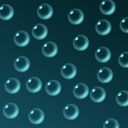

In [ ]:
#@title Load VGG and Target image {vertical-output: true}
vgg = models.vgg16(weights='IMAGENET1K_V1').features
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/bubbly/bubbly_0101.jpg'
style_img = imread(url, max_size=128)
style_img_torch = torch.tensor(style_img).permute(2, 0, 1).unsqueeze(0)

with torch.no_grad():
  loss_fn = RelaxedOTLoss(vgg, style_img_torch, n_samples=1024)
imshow(style_img)

In [ ]:
#@title NoiseNCA Architecture
def depthwise_conv(x, filters):
    """filters: [filter_n, h, w]"""
    b, ch, h, w = x.shape
    y = x.reshape(b * ch, 1, h, w)
    y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
    y = torch.nn.functional.conv2d(y, filters[:, None])
    return y.reshape(b, -1, h, w)

def merge_lap(z):
    # This function merges the lap_x and lap_y into a single laplacian filter
    b, c, h, w = z.shape # [b, 5 * chn, h, w]
    z = torch.stack([
        z[:, ::5],
        z[:, 1::5],
        z[:, 2::5],
        z[:, 3::5] + z[:, 4::5]
    ], dim=2)  # [b, chn, 4, h, w]
    return z.reshape(b, -1, h, w)  # [b, 4 * chn, h, w]


class NoiseNCA(torch.nn.Module):
    def __init__(self, chn=12, fc_dim=96, noise_level=0.1):
        super().__init__()
        self.chn = chn
        self.register_buffer("noise_level", torch.tensor([noise_level]))
        self.w1 = torch.nn.Conv2d(chn * 4, fc_dim, 1, bias=True)
        self.w2 = torch.nn.Conv2d(fc_dim, chn, 1, bias=False)

        torch.nn.init.xavier_normal_(self.w1.weight, gain=0.2)
        torch.nn.init.zeros_(self.w2.weight)

        with torch.no_grad():
            ident = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
            sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
            lap_x = torch.tensor([[0.5, 0.0, 0.5], [2.0, -6.0, 2.0], [0.5, 0.0, 0.5]])

            self.filters = torch.stack([ident, sobel_x, sobel_x.T, lap_x, lap_x.T])

    def perception(self, s, dx=1.0, dy=1.0):
        z = depthwise_conv(s, self.filters)  # [b, 5 * chn, h, w]
        if isinstance(dx, float) and dx == 1.0 and isinstance(dy, float) == 1.0:
            return merge_lap(z)

        if not isinstance(dx, torch.Tensor) or dx.ndim != 3:
            dx = torch.tensor([dx], device=s.device)[:, None, None]  # [1, 1, 1]
        if not isinstance(dy, torch.Tensor) or dy.ndim != 3:
            dy = torch.tensor([dy], device=s.device)[:, None, None]  # [1, 1, 1]

        scale = 1.0 / torch.stack([torch.ones_like(dx), dx, dy, dx ** 2, dy ** 2], dim=1)
        scale = torch.tile(scale, (1, self.chn, 1, 1))
        z = z * scale
        return merge_lap(z)

    def forward(self, s, dx=1.0, dy=1.0, dt=1.0):
      z = self.perception(s, dx, dy)
      delta_s = self.w2(torch.relu(self.w1(z)))
      return s + delta_s * dt


    def seed(self, n, h=128, w=128):
        return (torch.rand(n, self.chn, h, w) - 0.5) * self.noise_level

def to_rgb(s):
    return s[..., :3, :, :] + 0.5

param_n = sum(p.numel() for p in NoiseNCA().parameters())
print('NoiseNCA param count:', param_n)

NoiseNCA param count: 5856


In [ ]:
#@title Setup Training
model = NoiseNCA()
opt = torch.optim.Adam(model.parameters(), 1e-3, capturable=True)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []
with torch.no_grad():
    pool = model.seed(256)


        step_n: 3996
        loss: 2.717433452606201
        lr: 8.999999999999999e-05

  pl.ylim(np.min(loss_log), loss_log[0])



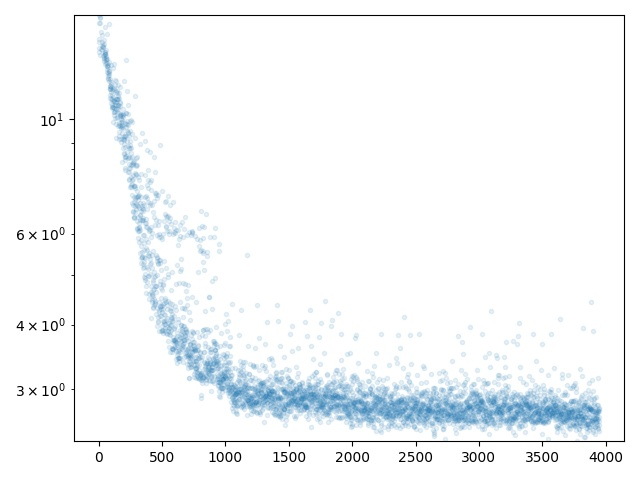

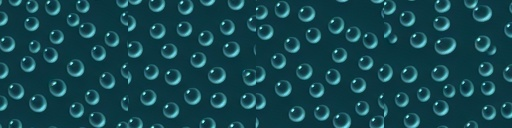

In [ ]:

# @title Training loop {vertical-output: true}
# This block is adapted from the self-org textures notebook.

for i in range(4000):
    with torch.no_grad():
        batch_idx = np.random.choice(len(pool), 4, replace=False)
        s = pool[batch_idx]
        if i % 8 == 0:
            s[:1] = model.seed(1)
    step_n = np.random.randint(32, 96)
    for k in range(step_n):
        s = model(s)


    overflow_loss = (s - s.clamp(-1.0, 1.0)).abs().sum()
    loss = loss_fn(to_rgb(s)) + overflow_loss
    with torch.no_grad():
        loss.backward()
        for p in model.parameters():
            p.grad /= (p.grad.norm() + 1e-8)  # normalize gradients
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        pool[batch_idx] = s  # update pool

        loss_log.append(loss.item())
        if i % 5 == 0:
            display(Markdown(f'''
        step_n: {len(loss_log)}
        loss: {loss.item()}
        lr: {lr_sched.get_last_lr()[0]}'''), display_id='stats')
        if i % 50 == 0:
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.tight_layout()
            imshow(grab_plot(), id='log')
            imgs = to_rgb(s).permute([0, 2, 3, 1]).cpu()
            imshow(np.hstack(imgs), id='batch')


In [ ]:
#@title Varying dt {vertical-output: true}

dt = 0.1 #@param {"type": "number"}
with VideoWriter() as vid, torch.no_grad():
  s = model.seed(1, 128)
  steps = int(1200 / dt)
  for step in tqdm(range(steps)):
      s[:] = model(s, dt=dt)

      if step % int(8 / dt) == 0:
          img = to_rgb(s[0]).permute(1, 2, 0).cpu()
          vid.add(zoom(img, 2))

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
#@title Varying dx, dy (Isotropic and Anisotropic Scaling) {vertical-output: true}

dx = 0.75 #@param {"type": "number"}
dy = 0.5 #@param {"type": "number"}
height = 128 #@param {"type": "integer"}
width = 128 #@param {"type": "integer"}
dt = min(1.0, dx**2, dy**2)
with VideoWriter() as vid, torch.no_grad():
  s = model.seed(1, height, width)
  steps = int(1200 / dt)
  for step in tqdm(range(steps)):
      s[:] = model(s, dx=dx, dy=dy, dt=dt)

      if step % int(8 / dt) == 0:
          img = to_rgb(s[0]).permute(1, 2, 0).cpu()
          vid.add(zoom(img, 2))

  0%|          | 0/4800 [00:00<?, ?it/s]

In [ ]:
#@title Multiscale Textures

height = 128 #@param {"type": "integer"}
log_max = 2.0
log_min = 0.5
dx_left = torch.logspace(-log_max, log_min, 2 * height, base=2.0)[None, None, :]
dx_right = torch.logspace(log_min, -log_max, 2 * height, base=2.0)[None, None, :]
dx = torch.zeros(1, height, height * 4)
dx[:, :, :] = torch.cat([dx_left, dx_right], dim=-1)
dy = dx
dt = 2 ** (-2.0 * log_max)
with VideoWriter() as vid, torch.no_grad():
  s = model.seed(1, height, height * 4)
  steps = int(1200 / dt)
  for step in tqdm(range(steps)):
      s[:] = model(s, dx=dx, dy=dy, dt=dt)

      if step % int(8 / dt) == 0:
          img = to_rgb(s[0]).permute(1, 2, 0).cpu()
          vid.add(zoom(img, 2))

  0%|          | 0/19200 [00:00<?, ?it/s]